In [1]:
import torch
import torchvision 
import os
from torch.utils import data
from PIL import Image
import torchvision.datasets as dset
import numpy as np

import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from tqdm.notebook import tqdm
import torchvision.models as models
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import matplotlib.pyplot as plt
import math
import pickle
from torchsummary import summary
from math import ceil
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#vital params



dataset_name="cifar10"
 
model_name="EfficientNetb2_sp"
version = "b2"

base_model = [
    # expand_ratio, channels, repeats, stride, kernel_size
    [1, 16, 1, 1, 3],
    [6, 24, 2, 2, 3],
    [6, 40, 2, 2, 5],
    [6, 80, 3, 2, 3],
    [6, 112, 3, 1, 5],
    [6, 192, 4, 2, 5],
    [6, 320, 1, 1, 3],
]

phi_values = {
    # tuple of: (phi_value, resolution, drop_rate)
    "b0": (0, 224, 0.2),  # alpha, beta, gamma, depth = alpha ** phi
    "b1": (0.5, 240, 0.2),
    "b2": (1, 260, 0.3),
    "b3": (2, 300, 0.3),
    "b4": (3, 380, 0.4),
    "b5": (4, 456, 0.4),
    "b6": (5, 528, 0.5),
    "b7": (6, 600, 0.5),
}

phi, res, drop_rate = phi_values[version]
#hyperparameters
batch_size=20
num_classes=-1
learning_rate=0.001
image_size=(res,res)

if dataset_name == "tsrd":
    num_classes=58
elif dataset_name == "cifar10":
    num_classes=10


print("Model: "+model_name +" with {} classes".format(num_classes)+
      " running on: "+dataset_name)
print("The input image size is:{}".format(image_size))

Model: EfficientNetb2_sp with 10 classes running on: cifar10
The input image size is:(260, 260)


In [2]:
# load data through imagefolder
if dataset_name == "tsrd":
    main_transforms=transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.485, 0.456, 0.406] , std = [0.229, 0.224, 0.225]),

    ])

    train_dir = "../../dataset/data"
    head_train_set = dset.ImageFolder(train_dir,transform=main_transforms)
    train_set, valid_set = data.random_split(head_train_set, [5000, 998])
    train_set, test_set = data.random_split(train_set,[4000, 1000])


    train_dataloader=torch.utils.data.DataLoader(train_set,
                                                 batch_size=batch_size,
                                                 shuffle=True)

    val_dataloader=torch.utils.data.DataLoader(valid_set,
                                                 batch_size=batch_size,
                                                 shuffle=True)

    test_dataloader=torch.utils.data.DataLoader(test_set,
                                                 batch_size=1,
                                                 shuffle=True)
    print(head_train_set.class_to_idx)
elif dataset_name == "cifar10":
    
    main_transforms=transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.5, 0.5, 0.5] , std = [0.5, 0.5, 0.5]),

    ])

    bigtrain_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=main_transforms)
    train_set, valid_set = data.random_split(bigtrain_set, [40000, 10000])
    test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=main_transforms)


    train_dataloader = torch.utils.data.DataLoader(train_set, 
                                                   batch_size=batch_size, 
                                                   shuffle=True, num_workers=2)

    val_dataloader = torch.utils.data.DataLoader(valid_set, 
                                                   batch_size=batch_size, 
                                                   shuffle=True, num_workers=2)

    test_dataloader = torch.utils.data.DataLoader(test_set,
                                                  batch_size=batch_size,
                                                  shuffle=False, num_workers=2)
    





print("Dataset size: Train: {}, Valid: {}, Test: {}"
      .format(len(train_set),len(valid_set),len(test_set)))


print(train_set[0][0].shape)
print("Datasets loaded and prepared")

Files already downloaded and verified
Files already downloaded and verified
Dataset size: Train: 40000, Valid: 10000, Test: 10000
torch.Size([3, 260, 260])
Datasets loaded and prepared


In [3]:

class CNNBlock(nn.Module):
    def __init__(
            self, in_channels, out_channels, kernel_size, stride, padding, groups=1
    ):
        super(CNNBlock, self).__init__()
        self.cnn = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            groups=groups,
            bias=False,
        )
        self.bn = nn.BatchNorm2d(out_channels)
        self.silu = nn.SiLU() # SiLU <-> Swish

    def forward(self, x):
        return self.silu(self.bn(self.cnn(x)))

class SqueezeExcitation(nn.Module):
    def __init__(self, in_channels, reduced_dim):
        super(SqueezeExcitation, self).__init__()
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1), # C x H x W -> C x 1 x 1
            nn.Conv2d(in_channels, reduced_dim, 1),
            nn.SiLU(),
            nn.Conv2d(reduced_dim, in_channels, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return x * self.se(x)

class InvertedResidualBlock(nn.Module):
    def __init__(
            self,
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            expand_ratio,
            reduction=4, # squeeze excitation
            survival_prob=0.8, # for stochastic depth
    ):
        super(InvertedResidualBlock, self).__init__()
        self.survival_prob = 0.8
        self.use_residual = in_channels == out_channels and stride == 1
        hidden_dim = in_channels * expand_ratio
        self.expand = in_channels != hidden_dim
        reduced_dim = int(in_channels / reduction)

        if self.expand:
            self.expand_conv = CNNBlock(
                in_channels, hidden_dim, kernel_size=3, stride=1, padding=1,
            )

        self.conv = nn.Sequential(
            CNNBlock(
                hidden_dim, hidden_dim, kernel_size, stride, padding, groups=hidden_dim,
            ),
            SqueezeExcitation(hidden_dim, reduced_dim),
            nn.Conv2d(hidden_dim, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
        )

    def stochastic_depth(self, x):
        if not self.training:
            return x

        binary_tensor = torch.rand(x.shape[0], 1, 1, 1, device=x.device) < self.survival_prob
        return torch.div(x, self.survival_prob) * binary_tensor

    def forward(self, inputs):
        x = self.expand_conv(inputs) if self.expand else inputs

        if self.use_residual:
            return self.stochastic_depth(self.conv(x)) + inputs
        else:
            return self.conv(x)


class EfficientNet(nn.Module):
    def __init__(self, version, num_classes):
        super(EfficientNet, self).__init__()
        width_factor, depth_factor, dropout_rate = self.calculate_factors(version)
        last_channels = ceil(1280 * width_factor)
        self.localization = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )

        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(37210, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.features = self.create_features(width_factor, depth_factor, last_channels)
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(last_channels, num_classes),
        )
        


        # Initialize the weights/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

    # Spatial transformer network forward function
    def stn(self, x):

        xs = self.localization(x)
        xs = xs.view(-1, 10 * 61 * 61)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)
        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)
        
        
    def calculate_factors(self, version, alpha=1.2, beta=1.1):
        phi, res, drop_rate = phi_values[version]
        depth_factor = alpha ** phi
        width_factor = beta ** phi
        return width_factor, depth_factor, drop_rate

    def create_features(self, width_factor, depth_factor, last_channels):
        channels = int(32 * width_factor)
        features = [CNNBlock(3, channels, 3, stride=2, padding=1)]
        in_channels = channels

        for expand_ratio, channels, repeats, stride, kernel_size in base_model:
            out_channels = 4*ceil(int(channels*width_factor) / 4)
            layers_repeats = ceil(repeats * depth_factor)

            for layer in range(layers_repeats):
                features.append(
                    InvertedResidualBlock(
                        in_channels,
                        out_channels,
                        expand_ratio=expand_ratio,
                        stride = stride if layer == 0 else 1,
                        kernel_size=kernel_size,
                        padding=kernel_size//2, # if k=1:pad=0, k=3:pad=1, k=5:pad=2
                    )
                )
                in_channels = out_channels

        features.append(
            CNNBlock(in_channels, last_channels, kernel_size=1, stride=1, padding=0)
        )

        return nn.Sequential(*features)

    def forward(self, x):
        self.stn(x)
        x = self.pool(self.features(x))
        
        return self.classifier(x.view(x.shape[0], -1))


def test():
    device = "cuda" if torch.cuda.is_available() else "cpu"
    version = "b2"
    phi, res, drop_rate = phi_values[version]
    num_examples = 4
    x = torch.randn((num_examples, 3, res, res)).to(device)
    model = EfficientNet(
        version=version,
        num_classes=num_classes,
    ).to(device)
    print(x.shape)
    print(model(x).shape) # (num_examples, num_classes)

test()

#print("Efficient Net model defined")

torch.Size([4, 3, 260, 260])
torch.Size([4, 10])


C:\Users\2080Ti\Anaconda3\envs\pytorch\lib\site-packages\torch\nn\functional.py:4044: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
C:\Users\2080Ti\Anaconda3\envs\pytorch\lib\site-packages\torch\nn\functional.py:3982: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


In [4]:
model = EfficientNet(
    version=version,
    num_classes=num_classes,
).to(device)

model = model.to(device)


from thop import profile
import colorama
from colorama import Fore,Style
#vital params
def getGFLOPS(test_model):
    model=test_model.to(device)
    input = torch.randn(1, 3, res, res).to(device)
    macs, params = profile(model, inputs=(input, ))

    print(Fore.BLUE + "The model requires: {:.4f} GFLOPS".format(macs/1000_000_000))
    print(Style.RESET_ALL)
    return macs
getGFLOPS(model)
#pretesting model for shape
x=torch.randn(batch_size,3,res,res)
x=x.to(device)
print(x.shape)
print(model(x).shape)
print(summary(model, input_size=(3, res, res)))
print("model shape ready")

#initailise network


#loss and optimizer
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=learning_rate)

print("model initialised")

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register count_bn() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.activation.SiLU'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.CNNBlock'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.activation.Sigmoid'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.SqueezeExcitation'>. Treat it as zero 

C:\Users\2080Ti\Anaconda3\envs\pytorch\lib\site-packages\torch\_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  ..\aten\src\ATen\native\BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 254, 254]           1,184
         MaxPool2d-2          [-1, 8, 127, 127]               0
              ReLU-3          [-1, 8, 127, 127]               0
            Conv2d-4         [-1, 10, 123, 123]           2,010
         MaxPool2d-5           [-1, 10, 61, 61]               0
              ReLU-6           [-1, 10, 61, 61]               0
            Linear-7                   [-1, 32]       1,190,752
              ReLU-8                   [-1, 32]               0
            Linear-9                    [-1, 6]             198
           Conv2d-10         [-1, 35, 130, 130]             945
      BatchNorm2d-11         [-1, 35, 130, 130]              70
             SiLU-12         [-1, 35, 130, 130]               0
         CNNBlock-13         [-1, 35, 130, 130]               0
           Conv2d-14         [-1, 35, 1

In [5]:
# This is the testing part
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp
get_n_params(model)

def test(model, test_loader, istest= False, doprint=True):
    model.eval()
    test_loss = 0
    correct = 0
    TP=0
    TN=0
    FN=0
    FP=0
    test_loss = 0.0
    
    with torch.no_grad(): # disable gradient calculation for efficiency
        for data, target in tqdm(test_loader):
            # Prediction
            data=data.to(device=device)
            target=target.to(device=device)
            optimizer.zero_grad()
            
            output = model(data)
            loss=criterion(output,target)
            
            # Compute loss & accuracy
            test_loss+=loss.item()*data.size(0)

            
            #test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item() # how many predictions in this batch are correct
            
            #print("pred={} , target={} , judge={}".format(pred.item(),target.item(),pred.eq(target.view_as(pred)).sum().item()))

            
    #test_loss /= len(test_loader.dataset)

        
    # Log testing info
    if istest and doprint:
        
        print('Loss: {}   Accuracy: {}/{} ({:.3f}%)'.format(test_loss,
        correct, len(test_loader.dataset),
        100.000 * correct / len(test_loader.dataset)))
        print("Total parameters: {}".format(get_n_params(model)))
    elif doprint:
        print('Accuracy: {}/{} ({:.3f}%)'.format(
        correct, len(test_loader.dataset),
        100.000 * correct / len(test_loader.dataset)))
    return 100.000 * correct / len(test_loader.dataset)
        

print("test defined")

def testshouldearlystop(acclist,minepoch,epochwindow,accwindow):
    runlen=len(acclist)
    if(runlen<minepoch):
        return False
    elif(acclist[-1]>acclist[-2]):
        return False
    
    watchwindow=acclist[-epochwindow:]
    shouldjump=True
    sum=0
    for i in watchwindow:
        sum+=i
    avg = sum/epochwindow
    for i in watchwindow:
        if abs(i-avg)>(accwindow):
            shouldjump=False
    return shouldjump
print("early stop defined")

test defined
early stop defined


In [6]:
now=datetime.now()
dt_string = now.strftime("%Y%m%d%H%M%S")

tensorboard_string="runs/"+model_name+dt_string
grandstore_string="grandstore/"+dataset_name+"_"+model_name+dt_string+".pkl"
print("tensorboard_string:")
print(tensorboard_string)
print("grandstore_string:")
print(grandstore_string)


writer = SummaryWriter(tensorboard_string)


tensorboard_string:
runs/EfficientNetb2_sp20211123153008
grandstore_string:
grandstore/cifar10_EfficientNetb2_sp20211123153008.pkl


In [7]:
#This is the training part

# Grand_store={
#     'total_epoch_run':-1
#     'topmodels':-1
#     'lastmodel':-1
#     'acclog':[]
#     'maxacc':-1
#     'minacc':101
# }
# train_epoch={
#     "numofepoch":-1
#     "accuracy":-1
#     "model_state":model.state_dict(),
#     "optim_state":optimizer.state_dict(),
#     "totaltrain_loss":totaltrain_loss,
#     "totalvalid_loss":totalvalid_loss
# }

def training(max_epoch=120, top_accuracy_track=3, grandstore={},
             minepoch=30,epochwindow=10,accwindow=0.35):

    grandstore['total_epoch_run']=0
    grandstore['topmodels']=[]
    grandstore['acclog']=[]
    grandstore['maxacc']=-1
    grandstore['minacc']=101
    
    for epoch in range(0,max_epoch):
        
        grandstore['total_epoch_run']=epoch+1
        
        train_epoch={
        "numofepoch":grandstore['total_epoch_run']
        }
    
        train_loss=0.0
        valid_loss=0.0
        print("Running epoch: {}".format(epoch+1))

        model.train()
        totaltrain_loss=0
        
        #this is the training part
        for data,target in tqdm(train_dataloader):
            data=data.to(device=device)
            target=target.to(device=device)
            output = model(data)
            loss = criterion(output, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()*data.size(0)
            totaltrain_loss += train_loss

        #this is the validation part
        model.eval()
        totalvalid_loss=0;
        correct = 0
        for data,target in tqdm(val_dataloader):
            data=data.to(device=device)
            target=target.to(device=device)
            output=model(data)
            loss=criterion(output,target)
            valid_loss=loss.item()*data.size(0)
            #train_loss = train_loss/len(train_dataloader.dataset)
            #valid_loss = valid_loss/len(val_dataloader.dataset)
            totalvalid_loss+=valid_loss
            
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item() # how many predictions in t
        

        training_accuracy=100. * correct / len(val_dataloader.dataset)
        train_epoch["accuracy"]=training_accuracy
        train_epoch["totaltrain_loss"]=totaltrain_loss
        train_epoch["totalvalid_loss"]=totalvalid_loss
        
        #writings to the GrandStore
        
        grandstore['acclog'].append(training_accuracy)
        
        if training_accuracy < grandstore['minacc']:
            grandstore['minacc'] = training_accuracy
            
        if training_accuracy > grandstore['maxacc']:
            grandstore['maxacc'] = training_accuracy
        

        if epoch < top_accuracy_track:
            thisepochtestresult=test(model,test_dataloader,istest = True,doprint=False)
            grandstore['topmodels'].append((training_accuracy,thisepochtestresult,epoch+1,train_epoch))
            #if error print this
            grandstore['topmodels'].sort()

        elif training_accuracy > grandstore['topmodels'][0][0]:
            thisepochtestresult=test(model,test_dataloader,istest = True,doprint=False)
            grandstore['topmodels'][0]=(training_accuracy,thisepochtestresult,epoch+1,train_epoch)
            #if error print this
            grandstore['topmodels'].sort()

        if epoch == (max_epoch-1):
            thisepochtestresult=test(model,test_dataloader,istest = True,doprint=False)
            grandstore['lastmodel']=(training_accuracy,thisepochtestresult,epoch+1,train_epoch)
                     
        writer.add_scalar('Training Loss',totaltrain_loss,global_step = epoch)
        writer.add_scalar('Valid Loss',totalvalid_loss,global_step = epoch)
        writer.add_scalar('Accuracy',training_accuracy,global_step = epoch)
        
        print('Accuracy: {:.3f}'.format(training_accuracy))
        print('Training Loss: {:.4f} \tValidation Loss: {:.4f}\n'.format(totaltrain_loss, totalvalid_loss))
        
        #early stopping criteria
        if(testshouldearlystop(acclist=grandstore['acclog'],
                               minepoch = minepoch,
                               epochwindow = epochwindow,
                               accwindow = accwindow)):
            print("early stop occured!!")
            thisepochtestresult=test(model,test_dataloader,istest = True,doprint=False)
            grandstore['lastmodel']=(training_accuracy,thisepochtestresult,epoch+1,train_epoch)
            return grandstore
    
    return grandstore
        


In [8]:
TOP_ACCURACY_TRACK = 10
# max_epoch=120, top_accuracy_track=3, grandstore={},
# minepoch=30,epochwindow=10,accwindow=0.35

Grandstore=training(max_epoch=240,
                    minepoch=150,
                    top_accuracy_track=TOP_ACCURACY_TRACK,
                    epochwindow=10,
                    accwindow=0.25                  
                   )

Running epoch: 1


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 47.030
Training Loss: 77969179.0166 	Validation Loss: 14293.9452

Running epoch: 2


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 65.690
Training Loss: 53800124.9925 	Validation Loss: 9534.0199

Running epoch: 3


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 74.290
Training Loss: 38287705.9537 	Validation Loss: 7316.6971

Running epoch: 4


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 77.940
Training Loss: 29585353.9635 	Validation Loss: 6341.1838

Running epoch: 5


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 80.750
Training Loss: 24628703.5984 	Validation Loss: 5520.6156

Running epoch: 6


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 81.790
Training Loss: 20983824.5284 	Validation Loss: 5284.0141

Running epoch: 7


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 84.210
Training Loss: 18171303.1805 	Validation Loss: 4759.4252

Running epoch: 8


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 84.600
Training Loss: 15345294.9849 	Validation Loss: 4673.4181

Running epoch: 9


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 84.030
Training Loss: 13194574.0982 	Validation Loss: 4905.2529

Running epoch: 10


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 84.470
Training Loss: 11288534.6869 	Validation Loss: 4793.6386

Running epoch: 11


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 84.990
Training Loss: 9422280.8161 	Validation Loss: 4839.8674

Running epoch: 12


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.280
Training Loss: 8009663.3240 	Validation Loss: 5057.2073

Running epoch: 13


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.670
Training Loss: 6950191.2458 	Validation Loss: 5160.4629

Running epoch: 14


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.240
Training Loss: 6280772.4847 	Validation Loss: 5292.3528

Running epoch: 15


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.380
Training Loss: 5455090.3013 	Validation Loss: 5488.9940

Running epoch: 16


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.660
Training Loss: 5120476.2968 	Validation Loss: 5416.6382

Running epoch: 17


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 84.940
Training Loss: 4348280.6078 	Validation Loss: 5877.1116

Running epoch: 18


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.050
Training Loss: 3995772.8851 	Validation Loss: 5929.8616

Running epoch: 19


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.150
Training Loss: 3481666.2571 	Validation Loss: 5900.0321

Running epoch: 20


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.460
Training Loss: 3580247.5051 	Validation Loss: 6187.9439

Running epoch: 21


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.870
Training Loss: 3338931.1801 	Validation Loss: 6073.8240

Running epoch: 22


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.240
Training Loss: 3074035.5879 	Validation Loss: 6213.0481

Running epoch: 23


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.280
Training Loss: 3098899.1627 	Validation Loss: 6138.2812

Running epoch: 24


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.670
Training Loss: 2612730.1144 	Validation Loss: 6530.8218

Running epoch: 25


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.540
Training Loss: 2778884.6670 	Validation Loss: 6104.6660

Running epoch: 26


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.270
Training Loss: 2537614.5690 	Validation Loss: 6850.3130

Running epoch: 27


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.380
Training Loss: 2489492.5821 	Validation Loss: 5947.2470

Running epoch: 28


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.210
Training Loss: 1995023.2210 	Validation Loss: 6523.1715

Running epoch: 29


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.260
Training Loss: 2240983.4812 	Validation Loss: 6657.1631

Running epoch: 30


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.890
Training Loss: 2157887.2954 	Validation Loss: 6771.6800

Running epoch: 31


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.140
Training Loss: 2039787.5042 	Validation Loss: 6860.3594

Running epoch: 32


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.200
Training Loss: 2139411.1998 	Validation Loss: 6774.7482

Running epoch: 33


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.410
Training Loss: 2122667.9942 	Validation Loss: 6770.6861

Running epoch: 34


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.740
Training Loss: 1865238.8554 	Validation Loss: 6613.0438

Running epoch: 35


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.060
Training Loss: 1680788.0012 	Validation Loss: 7126.8078

Running epoch: 36


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.610
Training Loss: 1868420.2847 	Validation Loss: 7032.8280

Running epoch: 37


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.370
Training Loss: 1759340.9867 	Validation Loss: 7021.0103

Running epoch: 38


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.690
Training Loss: 1646234.8681 	Validation Loss: 6979.2283

Running epoch: 39


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.280
Training Loss: 1728924.3175 	Validation Loss: 6828.0707

Running epoch: 40


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.220
Training Loss: 1584265.9355 	Validation Loss: 7236.2373

Running epoch: 41


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.370
Training Loss: 1670420.4351 	Validation Loss: 6877.0692

Running epoch: 42


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.900
Training Loss: 1473480.0160 	Validation Loss: 7048.5632

Running epoch: 43


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.680
Training Loss: 1416129.9992 	Validation Loss: 7452.3404

Running epoch: 44


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.990
Training Loss: 1443753.1393 	Validation Loss: 7581.4803

Running epoch: 45


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.410
Training Loss: 1435374.6852 	Validation Loss: 7723.8493

Running epoch: 46


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.130
Training Loss: 1294589.9620 	Validation Loss: 7488.1362

Running epoch: 47


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.240
Training Loss: 1508490.3419 	Validation Loss: 7563.6790

Running epoch: 48


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.940
Training Loss: 1368267.7260 	Validation Loss: 7346.3185

Running epoch: 49


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.230
Training Loss: 1231757.2306 	Validation Loss: 7581.9565

Running epoch: 50


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.740
Training Loss: 1392974.7487 	Validation Loss: 7064.4953

Running epoch: 51


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.110
Training Loss: 1329052.2052 	Validation Loss: 7162.8570

Running epoch: 52


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.770
Training Loss: 1172591.7215 	Validation Loss: 7023.3382

Running epoch: 53


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.860
Training Loss: 1111636.6884 	Validation Loss: 7652.1265

Running epoch: 54


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.740
Training Loss: 1203503.3704 	Validation Loss: 7127.2174

Running epoch: 55


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.480
Training Loss: 1187630.8022 	Validation Loss: 7419.6359

Running epoch: 56


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.060
Training Loss: 997282.7617 	Validation Loss: 7087.0037

Running epoch: 57


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.440
Training Loss: 1055424.8243 	Validation Loss: 7987.0048

Running epoch: 58


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.650
Training Loss: 1130499.7844 	Validation Loss: 7672.7772

Running epoch: 59


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.770
Training Loss: 1099065.8662 	Validation Loss: 7935.1697

Running epoch: 60


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.070
Training Loss: 1202991.3575 	Validation Loss: 7341.8858

Running epoch: 61


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.050
Training Loss: 923735.9573 	Validation Loss: 7066.3487

Running epoch: 62


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.860
Training Loss: 1174063.4385 	Validation Loss: 7180.0378

Running epoch: 63


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.440
Training Loss: 1051467.8267 	Validation Loss: 7547.9669

Running epoch: 64


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.410
Training Loss: 1063623.5481 	Validation Loss: 7818.0870

Running epoch: 65


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.530
Training Loss: 1001644.5391 	Validation Loss: 7494.8809

Running epoch: 66


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.340
Training Loss: 943412.8516 	Validation Loss: 8073.2804

Running epoch: 67


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.950
Training Loss: 1064009.2350 	Validation Loss: 7272.5517

Running epoch: 68


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.270
Training Loss: 1026897.2376 	Validation Loss: 7172.8516

Running epoch: 69


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.140
Training Loss: 827621.7133 	Validation Loss: 7806.7198

Running epoch: 70


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.450
Training Loss: 714096.7438 	Validation Loss: 8090.1911

Running epoch: 71


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.510
Training Loss: 964937.9500 	Validation Loss: 7783.8161

Running epoch: 72


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.870
Training Loss: 940212.9155 	Validation Loss: 7367.9488

Running epoch: 73


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.470
Training Loss: 804699.6045 	Validation Loss: 8002.7116

Running epoch: 74


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.980
Training Loss: 899436.5120 	Validation Loss: 8333.9214

Running epoch: 75


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.570
Training Loss: 879017.8596 	Validation Loss: 8055.6695

Running epoch: 76


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.340
Training Loss: 919487.7445 	Validation Loss: 8104.5532

Running epoch: 77


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.860
Training Loss: 930343.5677 	Validation Loss: 7769.9745

Running epoch: 78


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.230
Training Loss: 772916.1769 	Validation Loss: 7963.5979

Running epoch: 79


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.680
Training Loss: 829449.9223 	Validation Loss: 7719.5311

Running epoch: 80


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.130
Training Loss: 711682.8545 	Validation Loss: 7386.1464

Running epoch: 81


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.580
Training Loss: 921921.7579 	Validation Loss: 7896.0552

Running epoch: 82


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.820
Training Loss: 776204.7355 	Validation Loss: 7786.5975

Running epoch: 83


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.730
Training Loss: 727631.1461 	Validation Loss: 7927.5423

Running epoch: 84


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.840
Training Loss: 740902.3504 	Validation Loss: 8066.1117

Running epoch: 85


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.480
Training Loss: 693803.5924 	Validation Loss: 8019.4825

Running epoch: 86


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.700
Training Loss: 760296.5595 	Validation Loss: 8175.4640

Running epoch: 87


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.160
Training Loss: 747192.3468 	Validation Loss: 7641.1863

Running epoch: 88


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.540
Training Loss: 754492.9758 	Validation Loss: 8049.3061

Running epoch: 89


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.250
Training Loss: 768436.6216 	Validation Loss: 8414.6016

Running epoch: 90


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.050
Training Loss: 742386.3273 	Validation Loss: 8046.8785

Running epoch: 91


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.920
Training Loss: 850670.0200 	Validation Loss: 7665.6958

Running epoch: 92


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.210
Training Loss: 665550.4754 	Validation Loss: 8348.0887

Running epoch: 93


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.720
Training Loss: 536340.4481 	Validation Loss: 7852.0623

Running epoch: 94


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.990
Training Loss: 785213.0002 	Validation Loss: 8075.2433

Running epoch: 95


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.910
Training Loss: 666616.0554 	Validation Loss: 7898.5850

Running epoch: 96


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.500
Training Loss: 607860.0566 	Validation Loss: 8782.1213

Running epoch: 97


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.670
Training Loss: 729330.1424 	Validation Loss: 8911.0661

Running epoch: 98


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.020
Training Loss: 791871.2372 	Validation Loss: 8317.2756

Running epoch: 99


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.020
Training Loss: 798085.2957 	Validation Loss: 7976.5554

Running epoch: 100


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.300
Training Loss: 769785.1014 	Validation Loss: 7818.5886

Running epoch: 101


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.480
Training Loss: 719408.1257 	Validation Loss: 7900.6822

Running epoch: 102


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.920
Training Loss: 641251.5141 	Validation Loss: 8169.7071

Running epoch: 103


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.560
Training Loss: 736893.8411 	Validation Loss: 7885.3465

Running epoch: 104


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.200
Training Loss: 626029.7853 	Validation Loss: 8166.3737

Running epoch: 105


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.840
Training Loss: 632108.3332 	Validation Loss: 8276.9884

Running epoch: 106


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.970
Training Loss: 675112.1233 	Validation Loss: 8100.2651

Running epoch: 107


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.500
Training Loss: 487429.8658 	Validation Loss: 8093.0207

Running epoch: 108


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.160
Training Loss: 513423.5237 	Validation Loss: 9056.0690

Running epoch: 109


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.950
Training Loss: 616681.1301 	Validation Loss: 8421.4454

Running epoch: 110


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.880
Training Loss: 826175.7237 	Validation Loss: 8424.8285

Running epoch: 111


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.480
Training Loss: 540002.8664 	Validation Loss: 8056.0860

Running epoch: 112


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.280
Training Loss: 528476.0654 	Validation Loss: 8032.3556

Running epoch: 113


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.930
Training Loss: 638484.0652 	Validation Loss: 8693.2602

Running epoch: 114


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.880
Training Loss: 573223.7361 	Validation Loss: 8897.1917

Running epoch: 115


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.760
Training Loss: 583063.1865 	Validation Loss: 8549.8678

Running epoch: 116


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.300
Training Loss: 566942.8369 	Validation Loss: 8495.5699

Running epoch: 117


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.140
Training Loss: 646836.7136 	Validation Loss: 8328.3721

Running epoch: 118


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.340
Training Loss: 551149.5200 	Validation Loss: 8176.1391

Running epoch: 119


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.470
Training Loss: 622584.7798 	Validation Loss: 8428.2977

Running epoch: 120


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.680
Training Loss: 475110.7060 	Validation Loss: 8763.7188

Running epoch: 121


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.160
Training Loss: 557676.8141 	Validation Loss: 8777.2839

Running epoch: 122


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.030
Training Loss: 545396.7092 	Validation Loss: 8962.8355

Running epoch: 123


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.710
Training Loss: 559562.1688 	Validation Loss: 8647.0316

Running epoch: 124


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.890
Training Loss: 614921.9915 	Validation Loss: 8468.9385

Running epoch: 125


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.850
Training Loss: 621038.9392 	Validation Loss: 8631.8471

Running epoch: 126


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.220
Training Loss: 593938.5043 	Validation Loss: 8363.7690

Running epoch: 127


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.520
Training Loss: 632930.7390 	Validation Loss: 8214.4432

Running epoch: 128


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.550
Training Loss: 414870.0730 	Validation Loss: 8382.1798

Running epoch: 129


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.430
Training Loss: 613419.2659 	Validation Loss: 8782.6724

Running epoch: 130


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.890
Training Loss: 684788.9657 	Validation Loss: 8670.8565

Running epoch: 131


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.990
Training Loss: 602001.8299 	Validation Loss: 8469.7702

Running epoch: 132


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.610
Training Loss: 454869.0724 	Validation Loss: 8330.9713

Running epoch: 133


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.260
Training Loss: 544330.8630 	Validation Loss: 8667.0834

Running epoch: 134


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.280
Training Loss: 455222.4984 	Validation Loss: 8498.8311

Running epoch: 135


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.200
Training Loss: 497383.3552 	Validation Loss: 8632.1226

Running epoch: 136


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.920
Training Loss: 564736.7889 	Validation Loss: 9173.1280

Running epoch: 137


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.260
Training Loss: 479986.4601 	Validation Loss: 8821.2684

Running epoch: 138


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.070
Training Loss: 571459.2442 	Validation Loss: 8595.0428

Running epoch: 139


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.090
Training Loss: 491345.3325 	Validation Loss: 8887.5884

Running epoch: 140


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.930
Training Loss: 502406.3508 	Validation Loss: 9166.7831

Running epoch: 141


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.740
Training Loss: 467725.9580 	Validation Loss: 8898.0589

Running epoch: 142


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.290
Training Loss: 609439.8057 	Validation Loss: 8709.6124

Running epoch: 143


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.520
Training Loss: 417473.5467 	Validation Loss: 9309.9745

Running epoch: 144


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.300
Training Loss: 465897.2202 	Validation Loss: 8917.6431

Running epoch: 145


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.540
Training Loss: 429916.0698 	Validation Loss: 8469.3971

Running epoch: 146


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.980
Training Loss: 363980.6648 	Validation Loss: 9417.3489

Running epoch: 147


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.100
Training Loss: 704205.3772 	Validation Loss: 9161.6013

Running epoch: 148


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.260
Training Loss: 518900.6022 	Validation Loss: 8981.7581

Running epoch: 149


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.710
Training Loss: 462513.8963 	Validation Loss: 8940.4478

Running epoch: 150


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.590
Training Loss: 510619.3823 	Validation Loss: 8453.8632

Running epoch: 151


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.410
Training Loss: 391900.0428 	Validation Loss: 8715.6971

Running epoch: 152


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.390
Training Loss: 543436.8044 	Validation Loss: 9034.7823

Running epoch: 153


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.990
Training Loss: 523162.1016 	Validation Loss: 9229.3845

Running epoch: 154


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.650
Training Loss: 477368.0184 	Validation Loss: 9477.6789

Running epoch: 155


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.330
Training Loss: 531917.2281 	Validation Loss: 8990.7128

Running epoch: 156


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.170
Training Loss: 422374.5345 	Validation Loss: 9149.3116

Running epoch: 157


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.940
Training Loss: 463086.4130 	Validation Loss: 9484.4886

Running epoch: 158


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.520
Training Loss: 524519.0307 	Validation Loss: 9929.7509

Running epoch: 159


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.520
Training Loss: 388197.0414 	Validation Loss: 9065.9988

Running epoch: 160


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.690
Training Loss: 441321.7505 	Validation Loss: 8849.3543

Running epoch: 161


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.560
Training Loss: 458195.9160 	Validation Loss: 8658.0603

Running epoch: 162


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.500
Training Loss: 449210.5492 	Validation Loss: 8554.7185

Running epoch: 163


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.320
Training Loss: 496668.6106 	Validation Loss: 8836.5726

Running epoch: 164


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.020
Training Loss: 349597.1307 	Validation Loss: 9285.8282

Running epoch: 165


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.390
Training Loss: 485900.8392 	Validation Loss: 9379.1051

Running epoch: 166


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.890
Training Loss: 363211.0908 	Validation Loss: 9394.6451

Running epoch: 167


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.450
Training Loss: 524203.7931 	Validation Loss: 8803.9287

Running epoch: 168


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.660
Training Loss: 353991.0946 	Validation Loss: 9871.4266

Running epoch: 169


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.350
Training Loss: 517204.9683 	Validation Loss: 9217.8723

Running epoch: 170


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.970
Training Loss: 506369.9415 	Validation Loss: 9178.8313

Running epoch: 171


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.110
Training Loss: 335904.1282 	Validation Loss: 9461.7544

Running epoch: 172


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.330
Training Loss: 494429.9416 	Validation Loss: 9051.5687

Running epoch: 173


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.390
Training Loss: 466920.7710 	Validation Loss: 8821.2749

Running epoch: 174


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 85.880
Training Loss: 421445.1024 	Validation Loss: 10363.9344

Running epoch: 175


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.190
Training Loss: 488662.4108 	Validation Loss: 9430.3120

Running epoch: 176


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.840
Training Loss: 431481.0694 	Validation Loss: 9166.8976

Running epoch: 177


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.400
Training Loss: 466740.5228 	Validation Loss: 9587.3176

Running epoch: 178


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.190
Training Loss: 416564.0293 	Validation Loss: 9483.3454

Running epoch: 179


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.730
Training Loss: 389876.2121 	Validation Loss: 9858.1836

Running epoch: 180


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.160
Training Loss: 495916.1246 	Validation Loss: 9328.1958

Running epoch: 181


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.550
Training Loss: 384785.0095 	Validation Loss: 8835.4932

Running epoch: 182


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.820
Training Loss: 389303.5493 	Validation Loss: 9438.1270

Running epoch: 183


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.880
Training Loss: 322143.7536 	Validation Loss: 9589.9339

Running epoch: 184


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.750
Training Loss: 376546.7082 	Validation Loss: 9930.1987

Running epoch: 185


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.700
Training Loss: 429708.0497 	Validation Loss: 9868.9883

Running epoch: 186


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.170
Training Loss: 395040.9335 	Validation Loss: 9676.6203

Running epoch: 187


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.880
Training Loss: 592997.8517 	Validation Loss: 9464.1333

Running epoch: 188


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.240
Training Loss: 330595.8954 	Validation Loss: 9728.3049

Running epoch: 189


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.290
Training Loss: 536599.9917 	Validation Loss: 9576.2111

Running epoch: 190


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.220
Training Loss: 437673.2408 	Validation Loss: 9471.4249

Running epoch: 191


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.920
Training Loss: 364221.7801 	Validation Loss: 9753.2957

Running epoch: 192


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.310
Training Loss: 452684.8895 	Validation Loss: 9564.6781

Running epoch: 193


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.300
Training Loss: 432743.0758 	Validation Loss: 9183.3985

Running epoch: 194


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.980
Training Loss: 325326.9798 	Validation Loss: 10052.7637

Running epoch: 195


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.100
Training Loss: 458671.7416 	Validation Loss: 9658.4921

Running epoch: 196


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.450
Training Loss: 362010.8217 	Validation Loss: 9426.2863

Running epoch: 197


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.150
Training Loss: 461808.7191 	Validation Loss: 9539.6393

Running epoch: 198


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.520
Training Loss: 449736.8362 	Validation Loss: 8908.1976

Running epoch: 199


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.750
Training Loss: 335826.4521 	Validation Loss: 9480.9901

Running epoch: 200


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.340
Training Loss: 422765.0893 	Validation Loss: 9046.5221

Running epoch: 201


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.310
Training Loss: 387856.0898 	Validation Loss: 9205.9141

Running epoch: 202


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.070
Training Loss: 346400.6872 	Validation Loss: 9651.4768

Running epoch: 203


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.770
Training Loss: 346801.9850 	Validation Loss: 9616.7931

Running epoch: 204


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.180
Training Loss: 438320.7163 	Validation Loss: 9308.3638

Running epoch: 205


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.270
Training Loss: 337641.6760 	Validation Loss: 10061.4341

Running epoch: 206


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.930
Training Loss: 350698.0811 	Validation Loss: 10111.9239

Running epoch: 207


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.740
Training Loss: 355912.9183 	Validation Loss: 9874.3844

Running epoch: 208


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.800
Training Loss: 431444.5417 	Validation Loss: 9973.8251

Running epoch: 209


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.710
Training Loss: 343400.1269 	Validation Loss: 9954.7899

Running epoch: 210


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.920
Training Loss: 279464.6186 	Validation Loss: 9727.4407

Running epoch: 211


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.750
Training Loss: 309786.6721 	Validation Loss: 10293.8508

Running epoch: 212


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.290
Training Loss: 457956.9476 	Validation Loss: 9299.7254

Running epoch: 213


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.210
Training Loss: 299893.7346 	Validation Loss: 9794.2067

Running epoch: 214


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.140
Training Loss: 350572.8792 	Validation Loss: 9529.1804

Running epoch: 215


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.250
Training Loss: 473243.9925 	Validation Loss: 9723.4597

Running epoch: 216


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.030
Training Loss: 375747.6017 	Validation Loss: 10014.8330

Running epoch: 217


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.650
Training Loss: 444590.1578 	Validation Loss: 9523.0287

Running epoch: 218


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.110
Training Loss: 280326.8581 	Validation Loss: 9895.2725

Running epoch: 219


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.650
Training Loss: 391358.6497 	Validation Loss: 9794.6443

Running epoch: 220


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.200
Training Loss: 549758.4547 	Validation Loss: 9544.4239

Running epoch: 221


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.130
Training Loss: 265954.1361 	Validation Loss: 10029.1859

Running epoch: 222


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.320
Training Loss: 453141.5818 	Validation Loss: 9982.5644

Running epoch: 223


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.350
Training Loss: 374745.3873 	Validation Loss: 9734.1456

Running epoch: 224


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.370
Training Loss: 413737.6596 	Validation Loss: 9596.7108

Running epoch: 225


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.650
Training Loss: 312691.6396 	Validation Loss: 10179.4324

Running epoch: 226


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.090
Training Loss: 372793.4232 	Validation Loss: 9869.8091

Running epoch: 227


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.080
Training Loss: 376830.0891 	Validation Loss: 9679.8265

Running epoch: 228


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.510
Training Loss: 295218.2607 	Validation Loss: 9453.5842

Running epoch: 229


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.180
Training Loss: 287865.6175 	Validation Loss: 9727.8899

Running epoch: 230


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.080
Training Loss: 376975.5154 	Validation Loss: 9800.2942

Running epoch: 231


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.110
Training Loss: 296356.3057 	Validation Loss: 10163.6306

Running epoch: 232


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.990
Training Loss: 330901.5116 	Validation Loss: 10712.1577

Running epoch: 233


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.090
Training Loss: 440275.2152 	Validation Loss: 10192.5585

Running epoch: 234


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.270
Training Loss: 318837.8582 	Validation Loss: 10101.8627

Running epoch: 235


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.630
Training Loss: 345129.7074 	Validation Loss: 10234.5470

Running epoch: 236


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.180
Training Loss: 387666.9457 	Validation Loss: 9854.9979

Running epoch: 237


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.100
Training Loss: 318108.5104 	Validation Loss: 9968.2820

Running epoch: 238


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 86.510
Training Loss: 309051.1008 	Validation Loss: 10364.0985

Running epoch: 239


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.230
Training Loss: 348452.3323 	Validation Loss: 10212.9321

Running epoch: 240


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Accuracy: 87.570
Training Loss: 456615.0534 	Validation Loss: 9504.0968



Total Run 216 epoch(s)
Accuracy MIN: 48.42 / MAX: 87.81

Top 10 performing epochs:
#1 epoch 136	||train_acc 87.81%	||test 87.3%
#2 epoch 140	||train_acc 87.59%	||test 87.1%
#3 epoch 87	||train_acc 87.58%	||test 87.04%
#4 epoch 82	||train_acc 87.53%	||test 86.74%
#5 epoch 169	||train_acc 87.52%	||test 86.95%
#6 epoch 150	||train_acc 87.51%	||test 87.19%
#7 epoch 183	||train_acc 87.51%	||test 86.85%
#8 epoch 153	||train_acc 87.47%	||test 87.33%
#9 epoch 99	||train_acc 87.47%	||test 87.12%
#10 epoch 131	||train_acc 87.46%	||test 87.28%

Last epoch:
epoch 216	||train_acc 87.04%	||test 86.88%

The model has parameters: 30681502


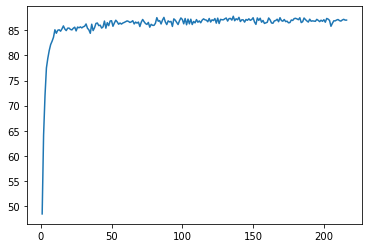

In [9]:
print("Total Run {} epoch(s)".format(Grandstore['total_epoch_run']))

plt.plot(*[range(1,Grandstore['total_epoch_run']+1)],Grandstore['acclog'])
print("Accuracy MIN: {} / MAX: {}".format(Grandstore['minacc'],Grandstore['maxacc']))
print()
print("Top {} performing epochs:".format(TOP_ACCURACY_TRACK))


gstm=Grandstore['topmodels']
for i in range(TOP_ACCURACY_TRACK):
    easy=gstm[TOP_ACCURACY_TRACK-i-1]
    print("#{} epoch {}\t||train_acc {}%\t||test {}%".format(i+1,easy[2],easy[0],easy[1]))
print()
print("Last epoch:")
lsmd=Grandstore['lastmodel']
print("epoch {}\t||train_acc {}%\t||test {}%".format(Grandstore['total_epoch_run'],lsmd[0],lsmd[1]))
      
print()
print("The model has parameters: {}".format(get_n_params(model)))
#grandstore['lastmodel']=((training_accuracy,train_epoch,thisepochtestresult))
# grandstore['lastmodel']=(training_accuracy,thisepochtestresult,epoch+1,train_epoch)

In [10]:
  
f1=open(grandstore_string,"wb")
pickle.dump(Grandstore,f1)
f1.close()

print("writings done!")
print("Files at: "+grandstore_string)

# with open(grandstore_string, 'rb') as file:
#     myvar = pickle.load(file)
#     print(myvar)

writings done!
Files at: grandstore/cifar10_EfficientNetb2_sp20211120200159.pkl
